<a href="https://colab.research.google.com/github/Upenbhatt/Seismology/blob/main/Seismic_B_values%2C_aftershock_analysis_and_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
import datetime as dt

# In Colab, working directory is usually /content
# So use absolute or relative paths accordingly, example:
csv_path = '/content/fullevents.csv'  # update this if your file is elsewhere

cat = pd.read_csv(csv_path)

YYYY=[]
MM=[]
DD=[]
lat=[]
lon=[]
dep=[]
mag=[]
un=[]
n=len(cat)

for i in range(0,n):
    YYYY_i=cat.iloc[i,0]
    MM_i=cat.iloc[i,1]
    DD_i=cat.iloc[i,2]
    lat_i=cat.iloc[i,3]
    lon_i=cat.iloc[i,4]
    dep_i=cat.iloc[i,5]
    mag_i=cat.iloc[i,6]
    un_i=cat.iloc[i,7]

    YYYY.append(YYYY_i)
    MM.append(MM_i)
    DD.append(DD_i)
    lat.append(lat_i)
    lon.append(lon_i)
    dep.append(dep_i)
    mag.append(mag_i)
    un.append(un_i)

con_mag=[]
for i in range(0,n):

    if un[i]=='mw' or un[i]=='mww' or un[i]=='mwc' or un[i]=='mwr' or un[i]=='mwb':
        con_mag_i=mag[i]

    elif un[i]=='mb':
        con_mag_i=round(np.exp(0.741+0.210*mag[i])-0.785,1)

    elif un[i]=='ms' and mag[i]<=5.5:
        con_mag_i=round(np.exp(2.133+0.063*mag[i])-6.205,1)

    elif un[i]=='ms' and mag[i]>5.5:
        con_mag_i=round(np.exp(-0.109+0.229*mag[i])+2.586,1)


    elif un[i]=='ml':
        con_mag_i=round((2*mag[i]/3)+1.15,1)

    else:
        con_mag_i=mag[i]

    con_mag.append(con_mag_i)

unit=[]
for i in range (0,n):
    unit.append('mw')

date=[]
for i in range(0,n):
    date_i=dt.date(YYYY[i],MM[i],DD[i])
    date.append(date_i)

combined=pd.DataFrame({'date':date,
                       'latitude':lat,
                       'longitude':lon,
                       'depth':dep,
                       'mag':con_mag,
                       'magType':unit})
combined=combined.sort_values(by='date',ascending=True).reset_index(drop=True)

yyyy=[]
mm=[]
dd=[]

for i in range(0,n):
    yyyy_i=combined.date[i].year
    mm_i=combined.date[i].month
    dd_i=combined.date[i].day

    yyyy.append(yyyy_i)
    mm.append(mm_i)
    dd.append(dd_i)

out=pd.DataFrame({'yyyy':yyyy,
                  'mm':mm,
                  'dd':dd,
                  'latitude':combined.latitude,
                  'longitude':combined.longitude,
                  'depth': combined.depth,
                  'mag':combined.mag,
                  'magType':combined.magType})

output_path = '/content/events.csv'
out.to_csv(output_path, index=False)
print(f'Saved converted catalog to {output_path}')



Saved converted catalog to /content/events.csv


In [ ]:
import pandas as pd
import datetime as dt
import math
import os

cwd = os.getcwd()
data = pd.read_csv(os.path.join(cwd, 'out_homogenized.csv'))

# Build datetime column
data['date'] = pd.to_datetime({"year": data['yyyy'], "month": data['mm'], "day": data['dd']})

data = data.sort_values('date').reset_index(drop=True)

n = len(data)
# We will keep a 'mainshock' boolean column
mainshock_mark = [True] * n

# Go through each event and mark those that are aftershocks or foreshocks
for i in range(n):
    if not mainshock_mark[i]:
        continue
    for j in range(i+1, n):
        if not mainshock_mark[j]:
            continue
        tdiff = (data['date'][j] - data['date'][i]).days
        # Compute distance (in km)
        x1 = math.radians(data['latitude'][i])
        x2 = math.radians(data['latitude'][j])
        y1 = math.radians(data['longitude'][i])
        y2 = math.radians(data['longitude'][j])
        L = math.acos(math.sin(x1)*math.sin(x2) + math.cos(x1)*math.cos(x2)*math.cos(y2-y1)) * 6371
        l = 10**(0.1238 * data['mag'][j] + 0.983)
        if data['mag'][j] >= 6.5:
            t = 10**(0.032 * data['mag'][j] + 2.7389)
        else:
            t = 10**(0.5409 * data['mag'][j] - 0.547)
        if L <= l and tdiff <= t:
            if data['mag'][i] > data['mag'][j]:
                mainshock_mark[j] = False
            else:
                mainshock_mark[i] = False
                break

mainshocks = data[mainshock_mark].copy()

mainshocks['yyyy'] = mainshocks['date'].dt.year
mainshocks['mm'] = mainshocks['date'].dt.month
mainshocks['dd'] = mainshocks['date'].dt.day

columns = ['yyyy', 'mm', 'dd', 'latitude', 'longitude', 'depth', 'mag', 'magType']
mainshocks[columns].to_csv(os.path.join(cwd, 'mainshock_only.csv'), index=False)


In [ ]:
import pandas as pd
import datetime as dt
import math
import os

cwd = os.getcwd()
data = pd.read_csv(os.path.join(cwd, 'out_homogenized.csv'))

# Build datetime column for catalog
data['date'] = pd.to_datetime(dict(year=data.yyyy, month=data.mm, day=data.dd))

# Mainshock parameters (replace with actual coordinates)
mainshock_date = pd.to_datetime('2024-12-17')
mainshock_lat = -17.6914
mainshock_lon = 168.0842
mainshock_mag = 7.3

# Gardner and Knopoff (1974) formulas
def gardner_knopoff_length(M):
    return 10 ** (0.1238 * M + 0.983)  # spatial length in km

def gardner_knopoff_time(M):
    if M >= 6.5:
        return 10 ** (0.032 * M + 2.7389)  # time in days
    else:
        return 10 ** (0.5409 * M - 0.547)

R = gardner_knopoff_length(mainshock_mag)  # spatial radius in km
T = gardner_knopoff_time(mainshock_mag)    # temporal limit in days

# Haversine distance function (km)
def haversine(lat1, lon1, lat2, lon2):
    from math import radians, sin, cos, sqrt, atan2
    R_earth = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R_earth * c

aftershock_mask = []
for idx, row in data.iterrows():
    delta_days = (row['date'] - mainshock_date).days
    dist = haversine(mainshock_lat, mainshock_lon, row['latitude'], row['longitude'])
    # Aftershock conditions:
    # 1. After mainshock date (delta_days>=0)
    # 2. Within Gardner-Knopoff space-time limits
    # 3. Smaller magnitude than mainshock
    if 0 <= delta_days <= T and dist <= R and row['mag'] < mainshock_mag:
        aftershock_mask.append(True)
    else:
        aftershock_mask.append(False)

aftershocks = data[aftershock_mask].copy()

# Save aftershocks catalog
output_fp = os.path.join(cwd, 'aftershocks_M7p3_GK.csv')
aftershocks.to_csv(output_fp, index=False)
print(f"Saved {len(aftershocks)} aftershocks to {output_fp}")


Saved 86 aftershocks to /content/aftershocks_M7p3_GK.csv


Mc estimation (magnitude of completeness)

Estimated Magnitude of Completeness (Mc): 4.50
Estimated b-value: 0.93


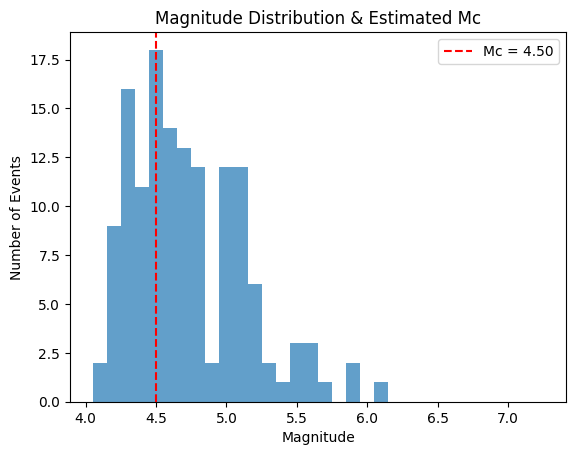

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def estimate_b_value(mags, Mc):
    """
    Estimate b-value using Maximum Likelihood Estimation (MLE),
    assuming all magnitudes >= Mc.
    """
    mags_filtered = mags[mags >= Mc]
    mean_mag = np.mean(mags_filtered)
    b = np.log10(np.e) / (mean_mag - (Mc - 0.05))
    return b

# Load your homogenized catalog CSV (adjust path)
df = pd.read_csv('/content/events.csv')

mags = df['mag'].values

# Calculate histogram for Mc estimate (Max Curvature)
bins = np.arange(min(mags), max(mags) + 0.1, 0.1)
hist, bin_edges = np.histogram(mags, bins=bins)

# Magnitude with highest frequency corresponds to Mc
peak_idx = np.argmax(hist)
Mc = bin_edges[peak_idx]

# Calculate b-value for mags >= Mc
b_value = estimate_b_value(mags, Mc)

print(f"Estimated Magnitude of Completeness (Mc): {Mc:.2f}")
print(f"Estimated b-value: {b_value:.2f}")

# Plot magnitude histogram and Mc line
plt.bar(bin_edges[:-1], hist, width=0.1, alpha=0.7)
plt.axvline(Mc, color='red', linestyle='--', label=f'Mc = {Mc:.2f}')
plt.xlabel('Magnitude')
plt.ylabel('Number of Events')
plt.title('Magnitude Distribution & Estimated Mc')
plt.legend()
plt.show()


aftershocks - using Gardner and Knoof

In [ ]:
import pandas as pd
import datetime as dt
import math
import os

df = pd.read_csv('/content/events.csv')

# Build datetime column for catalog
data['date'] = pd.to_datetime(dict(year=data.yyyy, month=data.mm, day=data.dd))

# Mainshock parameters (replace with actual coordinates)
mainshock_date = pd.to_datetime('2024-12-17')
mainshock_lat = -17.6914
mainshock_lon = 168.0842
mainshock_mag = 7.3

# Gardner and Knopoff (1974) formulas
def gardner_knopoff_length(M):
    return 10 ** (0.1238 * M + 0.983)  # spatial length in km

def gardner_knopoff_time(M):
    if M >= 6.5:
        return 10 ** (0.032 * M + 2.7389)  # time in days
    else:
        return 10 ** (0.5409 * M - 0.547)

R = gardner_knopoff_length(mainshock_mag)  # spatial radius in km
T = gardner_knopoff_time(mainshock_mag)    # temporal limit in days

# Haversine distance function (km)
def haversine(lat1, lon1, lat2, lon2):
    from math import radians, sin, cos, sqrt, atan2
    R_earth = 6371.0
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R_earth * c

aftershock_mask = []
for idx, row in data.iterrows():
    delta_days = (row['date'] - mainshock_date).days
    dist = haversine(mainshock_lat, mainshock_lon, row['latitude'], row['longitude'])
    # Aftershock conditions:
    # 1. After mainshock date (delta_days>=0)
    # 2. Within Gardner-Knopoff space-time limits
    # 3. Smaller magnitude than mainshock
    if 0 <= delta_days <= T and dist <= R and row['mag'] < mainshock_mag:
        aftershock_mask.append(True)
    else:
        aftershock_mask.append(False)

aftershocks = data[aftershock_mask].copy()

# Save aftershocks catalog
output_fp = os.path.join(cwd, 'aftershocks_M7p3_GK.csv')
aftershocks.to_csv(output_fp, index=False)
print(f"Saved {len(aftershocks)} aftershocks to {output_fp}")


Saved 86 aftershocks to /content/aftershocks_M7p3_GK.csv


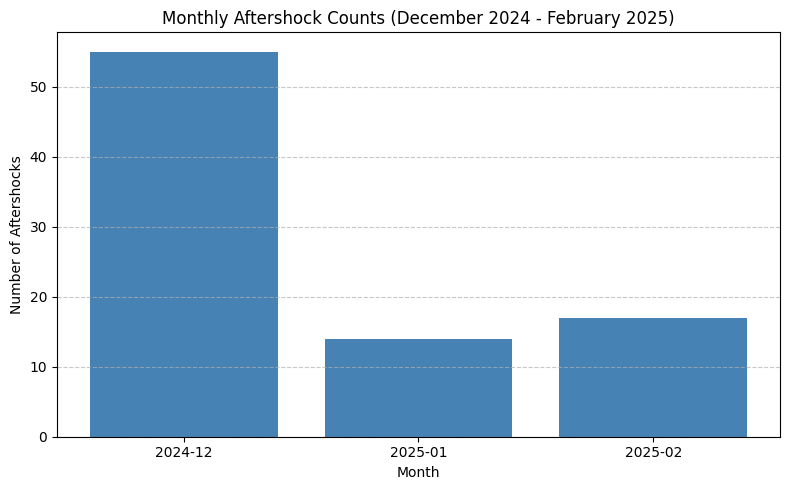

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the aftershocks catalog
aftershocks = pd.read_csv('/content/aftershocks_M7p3_GK.csv')

# Convert 'date' column to datetime
aftershocks['date'] = pd.to_datetime(aftershocks['date'])

# Extract year-month period
aftershocks['year_month'] = aftershocks['date'].dt.to_period('M')

# Filter months up to February 2025 (aftershock active period)
cutoff_month = pd.Period('2025-02')
aftershocks = aftershocks[aftershocks['year_month'] <= cutoff_month]

# Count aftershocks per month
monthly_counts = aftershocks.groupby('year_month').size()

# Convert index to string month labels for visual clarity
month_labels = [str(m) for m in monthly_counts.index]

# Plot bar graph
plt.figure(figsize=(8,5))
plt.bar(month_labels, monthly_counts.values, color='steelblue')
plt.xlabel('Month')
plt.ylabel('Number of Aftershocks')
plt.title('Monthly Aftershock Counts (December 2024 - February 2025)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


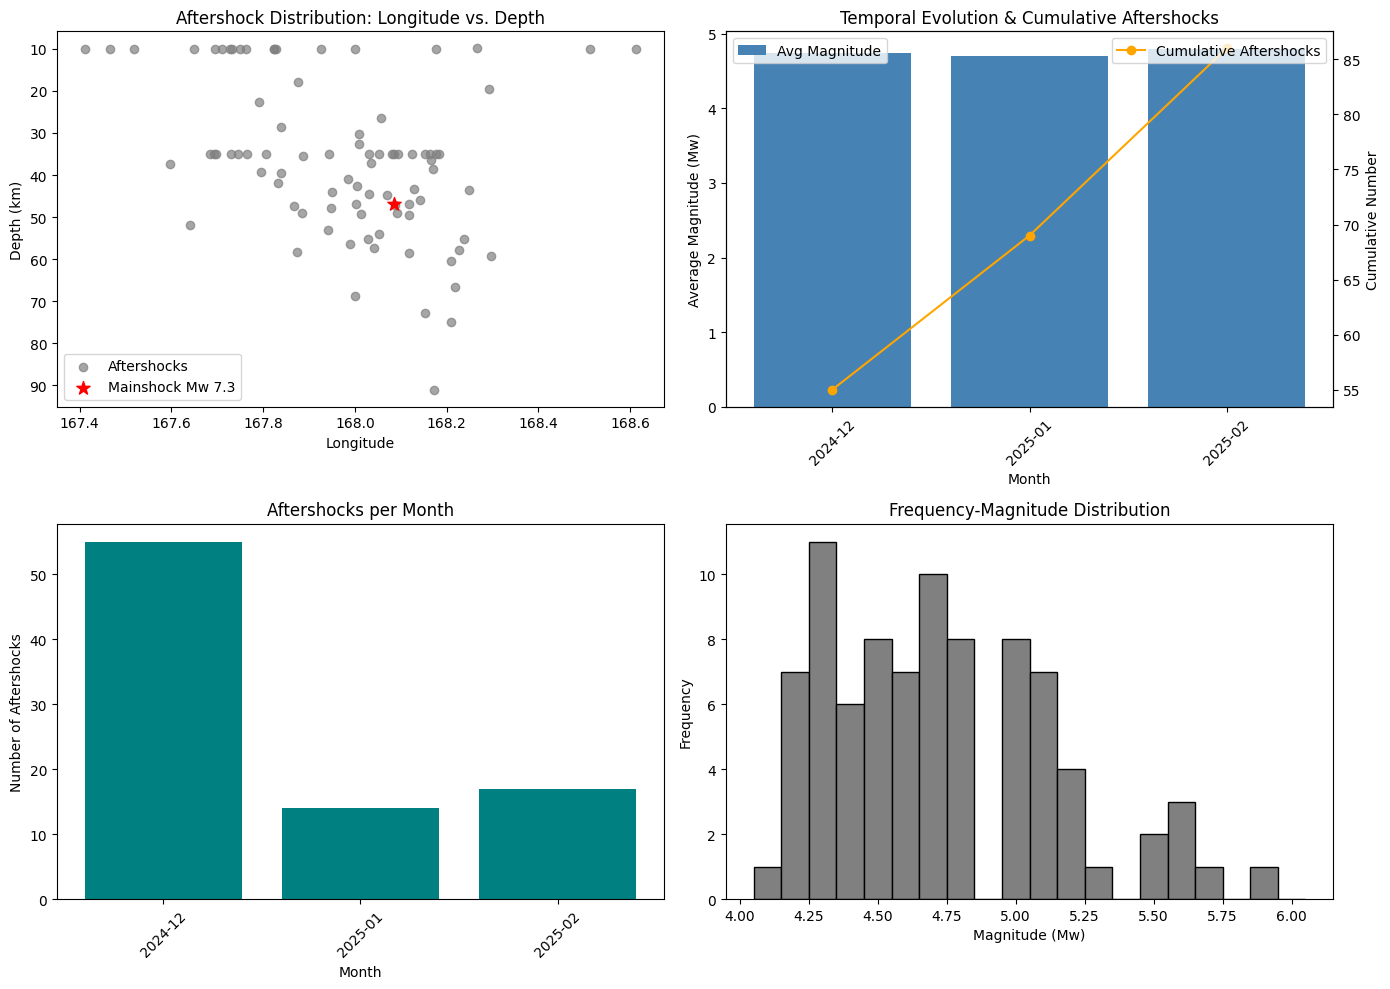

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load filtered aftershocks
aftershocks = pd.read_csv('/content/aftershocks_M7p3_GK.csv')
aftershocks['date'] = pd.to_datetime(aftershocks['date'])

# Mainshock info
mainshock_mag = 7.3
mainshock_lon = 168.0842
mainshock_depth = aftershocks.loc[aftershocks['mag'].idxmax()]['depth']  # approximate depth or define

# Prepare month-year for grouping
aftershocks['year_month'] = aftershocks['date'].dt.to_period('M')
monthly_counts = aftershocks.groupby('year_month').size().reindex(pd.period_range(aftershocks['year_month'].min(),
                                                                                  aftershocks['year_month'].max(), freq='M'), fill_value=0)
cumulative_counts = monthly_counts.cumsum()

# Avg magnitude per month for temporal evolution plot
monthly_avg_mag = aftershocks.groupby('year_month')['mag'].mean().reindex(monthly_counts.index)

# Frequency magnitude distribution
bins = np.arange(aftershocks['mag'].min(), aftershocks['mag'].max() + 0.1, 0.1)
freq_mag_hist, bin_edges = np.histogram(aftershocks['mag'], bins=bins)

fig, axs = plt.subplots(2, 2, figsize=(14, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# (1) Distribution of aftershocks (Longitude vs Depth), highlight mainshock
axs[0,0].scatter(aftershocks['longitude'], aftershocks['depth'], c='gray', alpha=0.7, label='Aftershocks')
axs[0,0].scatter(mainshock_lon, mainshock_depth, c='red', s=100, marker='*', label='Mainshock Mw 7.3')
axs[0,0].invert_yaxis()
axs[0,0].set_xlabel('Longitude')
axs[0,0].set_ylabel('Depth (km)')
axs[0,0].set_title('Aftershock Distribution: Longitude vs. Depth')
axs[0,0].legend()

# (2) Temporal evolution: Month vs Average Magnitude with cumulative aftershocks
ax1 = axs[0,1]
ax1.bar(monthly_counts.index.astype(str), monthly_avg_mag, color='steelblue', label='Avg Magnitude')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Magnitude (Mw)')
ax1.set_title('Temporal Evolution & Cumulative Aftershocks')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(cumulative_counts.index.astype(str), cumulative_counts.values, color='orange', marker='o', label='Cumulative Aftershocks')
ax2.set_ylabel('Cumulative Number')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# (3) Number of aftershocks per month (bar)
axs[1,0].bar(monthly_counts.index.astype(str), monthly_counts.values, color='teal')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Number of Aftershocks')
axs[1,0].set_title('Aftershocks per Month')
axs[1,0].tick_params(axis='x', rotation=45)

# (4) Frequency-magnitude distribution
axs[1,1].bar(bin_edges[:-1], freq_mag_hist, width=0.1, color='gray', edgecolor='black')
axs[1,1].set_xlabel('Magnitude (Mw)')
axs[1,1].set_ylabel('Frequency')
axs[1,1].set_title('Frequency-Magnitude Distribution')


plt.tight_layout()
plt.show()


/tmp/ipython-input-2673039509.py:32: RuntimeWarning: divide by zero encountered in log10
  logN = np.log10(cum_counts_d)


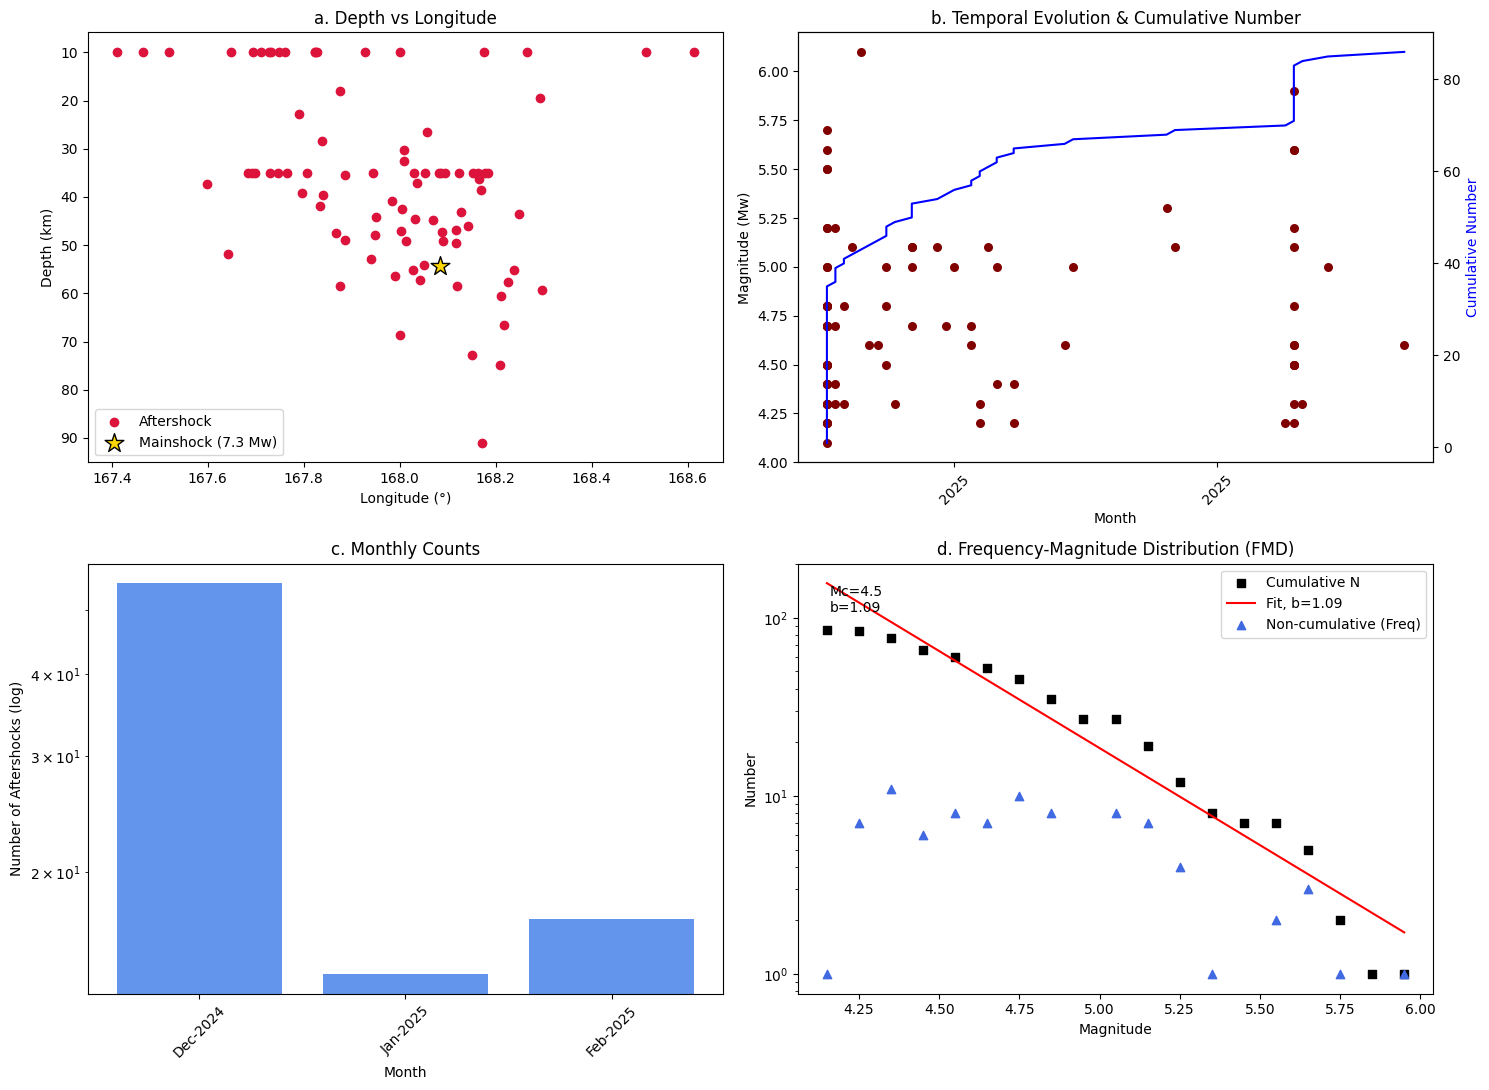

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Load catalogs (ensure your filenames are correct)
aftershocks = pd.read_csv('/content/aftershocks_M7p3_GK (1).csv')
cat = pd.read_csv('/content/events.csv')

# Create 'date' column from yyyy, mm, dd
for df in [aftershocks, cat]:
    df['date'] = pd.to_datetime(dict(year=df['yyyy'], month=df['mm'], day=df['dd']))

# Panel a: Longitude vs Depth
mainshock_lon, mainshock_lat, mainshock_mag = 168.0842, -17.6914, 7.3
mainshock_row = cat.loc[(cat['mag'] == mainshock_mag) & (abs(cat['longitude'] - mainshock_lon) < 0.1)]
mainshock_depth = mainshock_row['depth'].iloc[0] if not mainshock_row.empty else aftershocks.loc[aftershocks['mag'].idxmax()]['depth']

# Panel b/c: Monthly groupings
aftershocks['year_month'] = aftershocks['date'].dt.to_period('M')
months = pd.period_range(aftershocks['year_month'].min(), aftershocks['year_month'].max(), freq='M')
monthly_counts = aftershocks.groupby('year_month').size().reindex(months, fill_value=0)
cum_counts_b = np.arange(1, len(aftershocks) + 1)

# Panel d: FMD (Cumulative and non-cumulative) & b-value
Mc = 4.5
fmd_mags = aftershocks[aftershocks['mag'] >= Mc]['mag'].values
mag_bins = np.arange(aftershocks['mag'].min(), aftershocks['mag'].max() + 0.1, 0.1)
hist, bin_edges = np.histogram(aftershocks['mag'], bins=mag_bins)
cum_counts_d = np.cumsum(hist[::-1])[::-1]
mid_mag = bin_edges[:-1] + 0.05
logN = np.log10(cum_counts_d)
mask = cum_counts_d > 0

# Linear fit for cumulative (Gutenberg-Richter b-value estimate)
slope, intercept, _, _, _ = linregress(mid_mag[mask], logN[mask])
b_value = -slope

# Plotting panels
fig, axs = plt.subplots(2, 2, figsize=(15, 11))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# a. Depth vs Longitude
axs[0,0].scatter(aftershocks['longitude'], aftershocks['depth'], c='crimson', label='Aftershock')
axs[0,0].scatter(mainshock_lon, mainshock_depth, s=200, marker='*', c='gold', label='Mainshock (7.3 Mw)', edgecolor='black')
axs[0,0].invert_yaxis()
axs[0,0].set_xlabel('Longitude (°)')
axs[0,0].set_ylabel('Depth (km)')
axs[0,0].set_title('a. Depth vs Longitude')
axs[0,0].legend()

# b. Magnitude vs Month, Cumulative Number
axs[0,1].scatter(aftershocks['date'], aftershocks['mag'], s=30, color='maroon')
axs[0,1].set_xlabel('Month')
axs[0,1].set_ylabel('Magnitude (Mw)')
axs[0,1].set_title('b. Temporal Evolution & Cumulative Number')
axs[0,1].set_xticks(pd.date_range(aftershocks['date'].min(), aftershocks['date'].max(), freq='MS'))
axs[0,1].tick_params(axis='x', rotation=45)
axs2 = axs[0,1].twinx()
axs2.plot(aftershocks['date'], cum_counts_b, c='blue')
axs2.set_ylabel('Cumulative Number', color='blue')

# c. No. of aftershocks per month, log y
month_order = [m.strftime('%b-%Y') for m in months]
axs[1,0].bar(month_order, monthly_counts.values, color='cornflowerblue')
axs[1,0].set_yscale('log')
axs[1,0].set_xlabel('Month')
axs[1,0].set_ylabel('Number of Aftershocks (log)')
axs[1,0].set_title('c. Monthly Counts')
axs[1,0].tick_params(axis='x', rotation=45)

# d. Cumulative FMD and non-cumulative
axs[1,1].scatter(mid_mag[mask], cum_counts_d[mask], marker='s', color='k', label='Cumulative N')
axs[1,1].plot(mid_mag[mask], 10**(slope*mid_mag[mask] + intercept), color='red', label=f'Fit, b={-slope:.2f}')
axs[1,1].scatter(mid_mag[hist > 0], hist[hist > 0], marker='^', color='royalblue', label='Non-cumulative (Freq)')
axs[1,1].set_xlabel('Magnitude')
axs[1,1].set_ylabel('Number')
axs[1,1].set_yscale('log')
axs[1,1].set_title('d. Frequency-Magnitude Distribution (FMD)')
axs[1,1].legend()
axs[1,1].text(0.05, 0.95, f'Mc={Mc}\nb={-slope:.2f}', transform=axs[1,1].transAxes, verticalalignment='top')

plt.tight_layout()
plt.show()


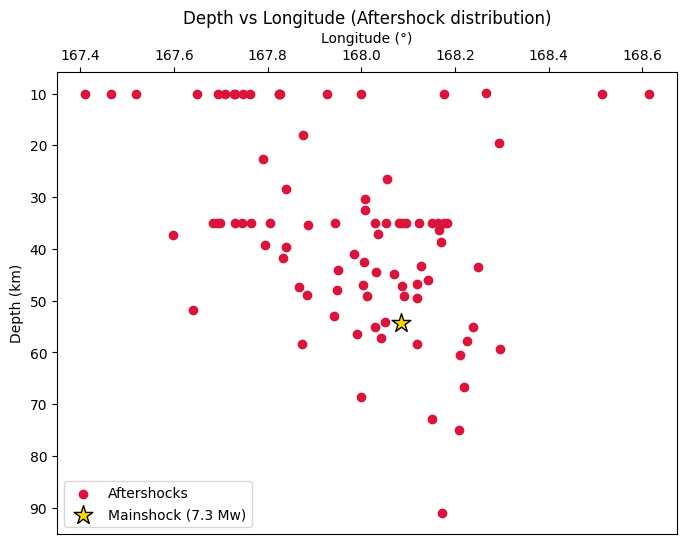

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your aftershocks data (adjust path if needed)
aftershocks = pd.read_csv('/content/aftershocks_M7p3_GK (1).csv')

# Mainshock details
mainshock_lon = 168.0842
mainshock_depth = 54.372  # Replace with actual depth if known

# Plot
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(aftershocks['longitude'], aftershocks['depth'], c='crimson', label='Aftershocks')

# Highlight mainshock
ax.scatter(mainshock_lon, mainshock_depth, s=200, marker='*', c='gold', edgecolor='black', label='Mainshock (7.3 Mw)')

# Set axis on top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# Invert y-axis (depth increasing downward)
ax.invert_yaxis()

# Labels and title
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Depth (km)')
ax.set_title('Depth vs Longitude (Aftershock distribution)')
ax.legend()

# Show plot
plt.show()


/tmp/ipython-input-1890125770.py:39: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend(loc='upper right')


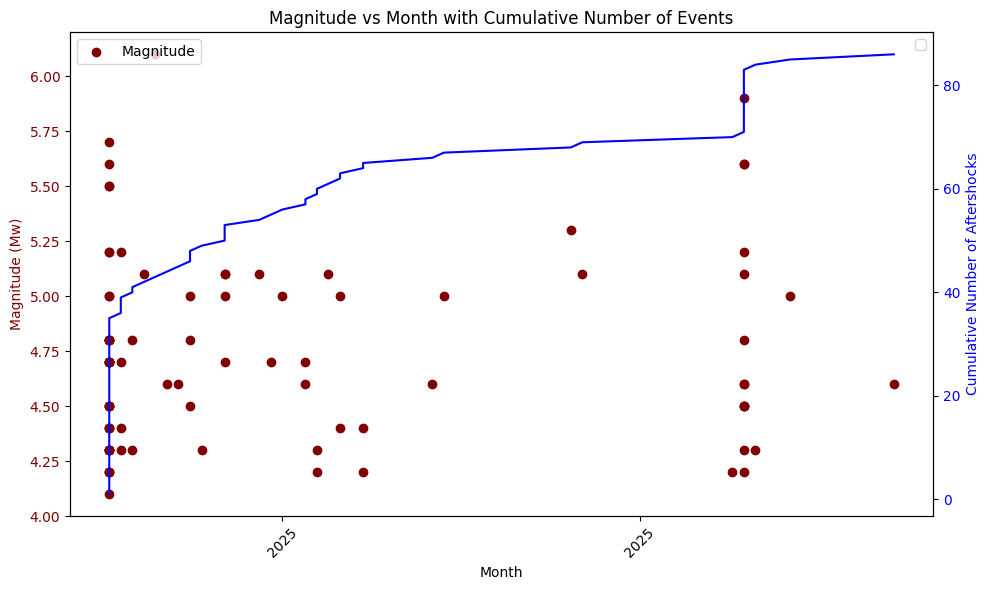

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your aftershocks data with separate yyyy, mm, dd columns
aftershocks = pd.read_csv('/content/aftershocks_M7p3_GK (1).csv')

# Create datetime column
aftershocks['date'] = pd.to_datetime(dict(year=aftershocks['yyyy'], month=aftershocks['mm'], day=aftershocks['dd']))

# Sort by date to ensure cumulative is correct
aftershocks = aftershocks.sort_values('date').reset_index(drop=True)

# Extract month-year period for plotting on x-axis
aftershocks['year_month'] = aftershocks['date'].dt.to_period('M')

# Prepare data for cumulative count
aftershocks['cum_count'] = range(1, len(aftershocks) + 1)

# Plotting
fig, ax1 = plt.subplots(figsize=(10,6))

# Scatter plot of magnitude vs time (month)
ax1.scatter(aftershocks['date'], aftershocks['mag'], color='maroon', label='Magnitude')
ax1.set_xlabel('Month')
ax1.set_ylabel('Magnitude (Mw)', color='maroon')
ax1.tick_params(axis='y', labelcolor='maroon')
ax1.set_title('Magnitude vs Month with Cumulative Number of Events')
ax1.set_xticks(pd.date_range(aftershocks['date'].min(), aftershocks['date'].max(), freq='MS'))
ax1.tick_params(axis='x', rotation=45)

# Secondary axis for cumulative number of events
ax2 = ax1.twinx()
ax2.plot(aftershocks['date'], aftershocks['cum_count'], color='blue')
ax2.set_ylabel('Cumulative Number of Aftershocks', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()


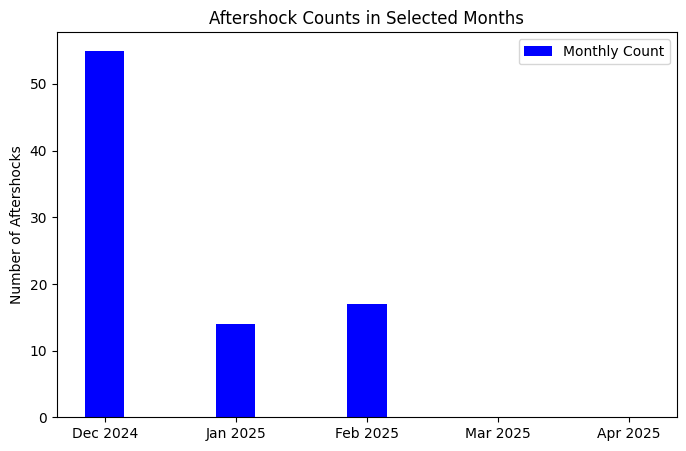

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
aftershocks = pd.read_csv('/content/aftershocks_M7p3_GK (1).csv')

# Create datetime from yyyy, mm, dd
aftershocks['date'] = pd.to_datetime(dict(year=aftershocks['yyyy'], month=aftershocks['mm'], day=aftershocks['dd']))

# Filter for the specific months
months_of_interest = ['2024-12', '2025-01', '2025-02', '2025-03', '2025-04']
aftershocks['year_month'] = aftershocks['date'].dt.to_period('M')
filtered = aftershocks[aftershocks['year_month'].astype(str).isin(months_of_interest)]

# Count per month
monthly_counts = filtered.groupby('year_month').size()

# Calculate cumulative counts
cum_counts = monthly_counts.cumsum()

# Dates for plotting
dates = ['Dec 2024', 'Jan 2025', 'Feb 2025', 'Mar 2025', 'Apr 2025']
counts = [monthly_counts.get(pd.Period(m), 0) for m in months_of_interest]
cumulative = [cum_counts.get(pd.Period(m), 0) for m in months_of_interest]

# Plot
plt.figure(figsize=(8,5))
plt.bar(dates, counts, color='blue', label='Monthly Count', width=0.3)
#plt.plot(dates, cumulative, color='orange', marker='o', label='Cumulative Count')
plt.ylabel('Number of Aftershocks')
plt.title('Aftershock Counts in Selected Months')
plt.legend()
plt.show()


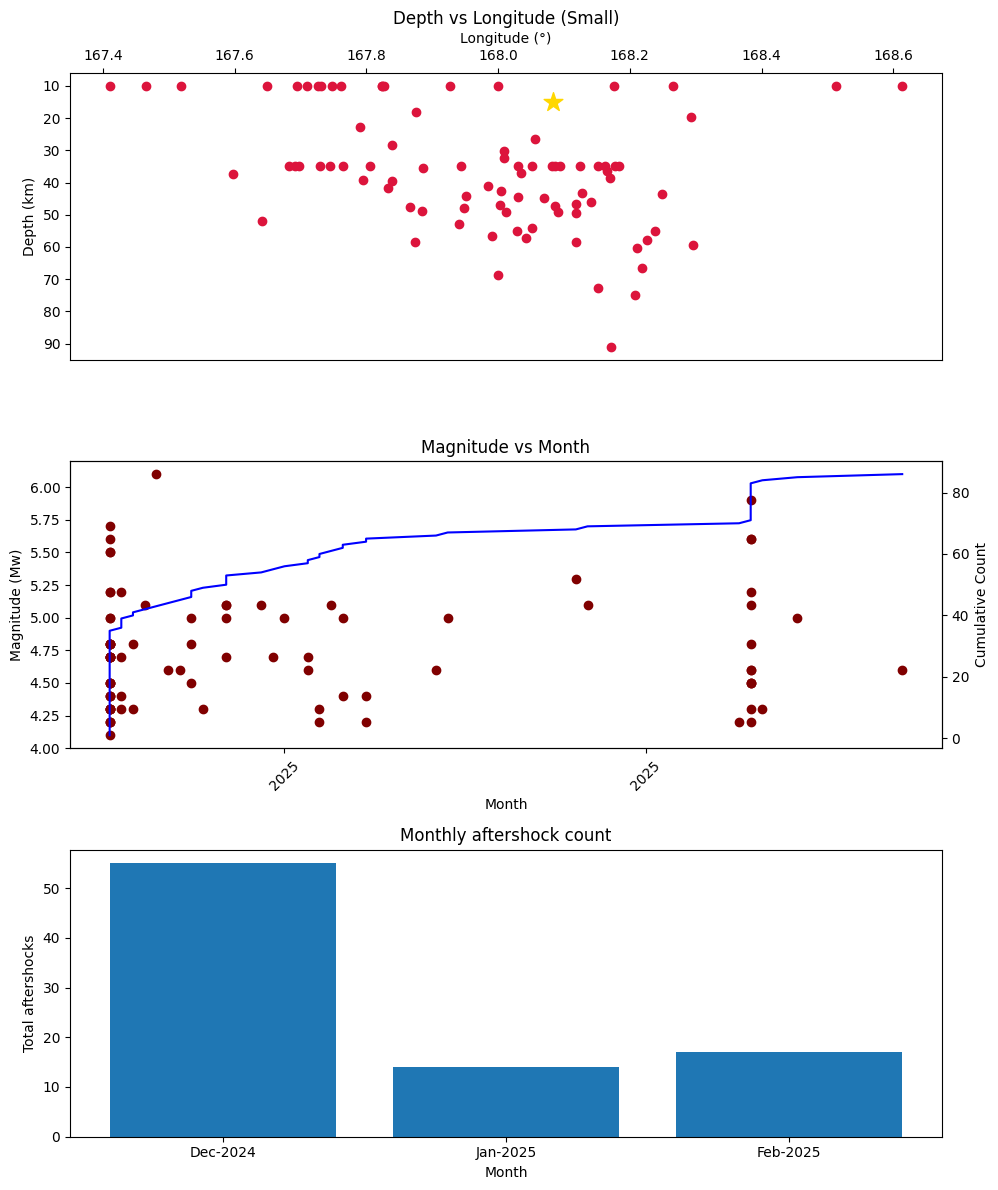

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
aftershocks = pd.read_csv('/content/aftershocks_M7p3_GK (1).csv')
aftershocks['date'] = pd.to_datetime(dict(year=aftershocks['yyyy'], month=aftershocks['mm'], day=aftershocks['dd']))

# Create figure with 3 small subplots in one page
fig, axs = plt.subplots(3, 1, figsize=(10, 12))
plt.subplots_adjust(hspace=0.6)

# 1. Depth vs Longitude
ax = axs[0]
ax.scatter(aftershocks['longitude'], aftershocks['depth'], c='crimson')
ax.scatter(168.0842, 15, s=200, marker='*', c='gold')
ax.invert_yaxis()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel('Longitude (°)')
ax.set_ylabel('Depth (km)')
ax.set_title('Depth vs Longitude (Small)')

# 2. Magnitude vs Month + Cumulative count
ax = axs[1]
ax.scatter(aftershocks['date'], aftershocks['mag'], c='maroon')
ax.set_xlabel('Month')
ax.set_ylabel('Magnitude (Mw)')
ax.set_title('Magnitude vs Month')
ax.set_xticks(pd.date_range(aftershocks['date'].min(), aftershocks['date'].max(), freq='MS'))
ax.tick_params(axis='x', rotation=45)

ax2 = ax.twinx()
cum_counts = range(1, len(aftershocks) + 1)
ax2.plot(aftershocks['date'], cum_counts, c='blue')
ax2.set_ylabel('Cumulative Count')

# 3. Monthly cumulative aftershock number
ax = axs[2]
monthly_counts = aftershocks.groupby(aftershocks['date'].dt.to_period('M')).size()
ax.bar([m.strftime('%b-%Y') for m in monthly_counts.index], monthly_counts.values)
ax.set_xlabel('Month')
ax.set_ylabel('Total aftershocks')
ax.set_title('Monthly aftershock count')

# Save and show
plt.tight_layout()
plt.savefig('/content/combined_small_plots.png', dpi=600)
plt.show()


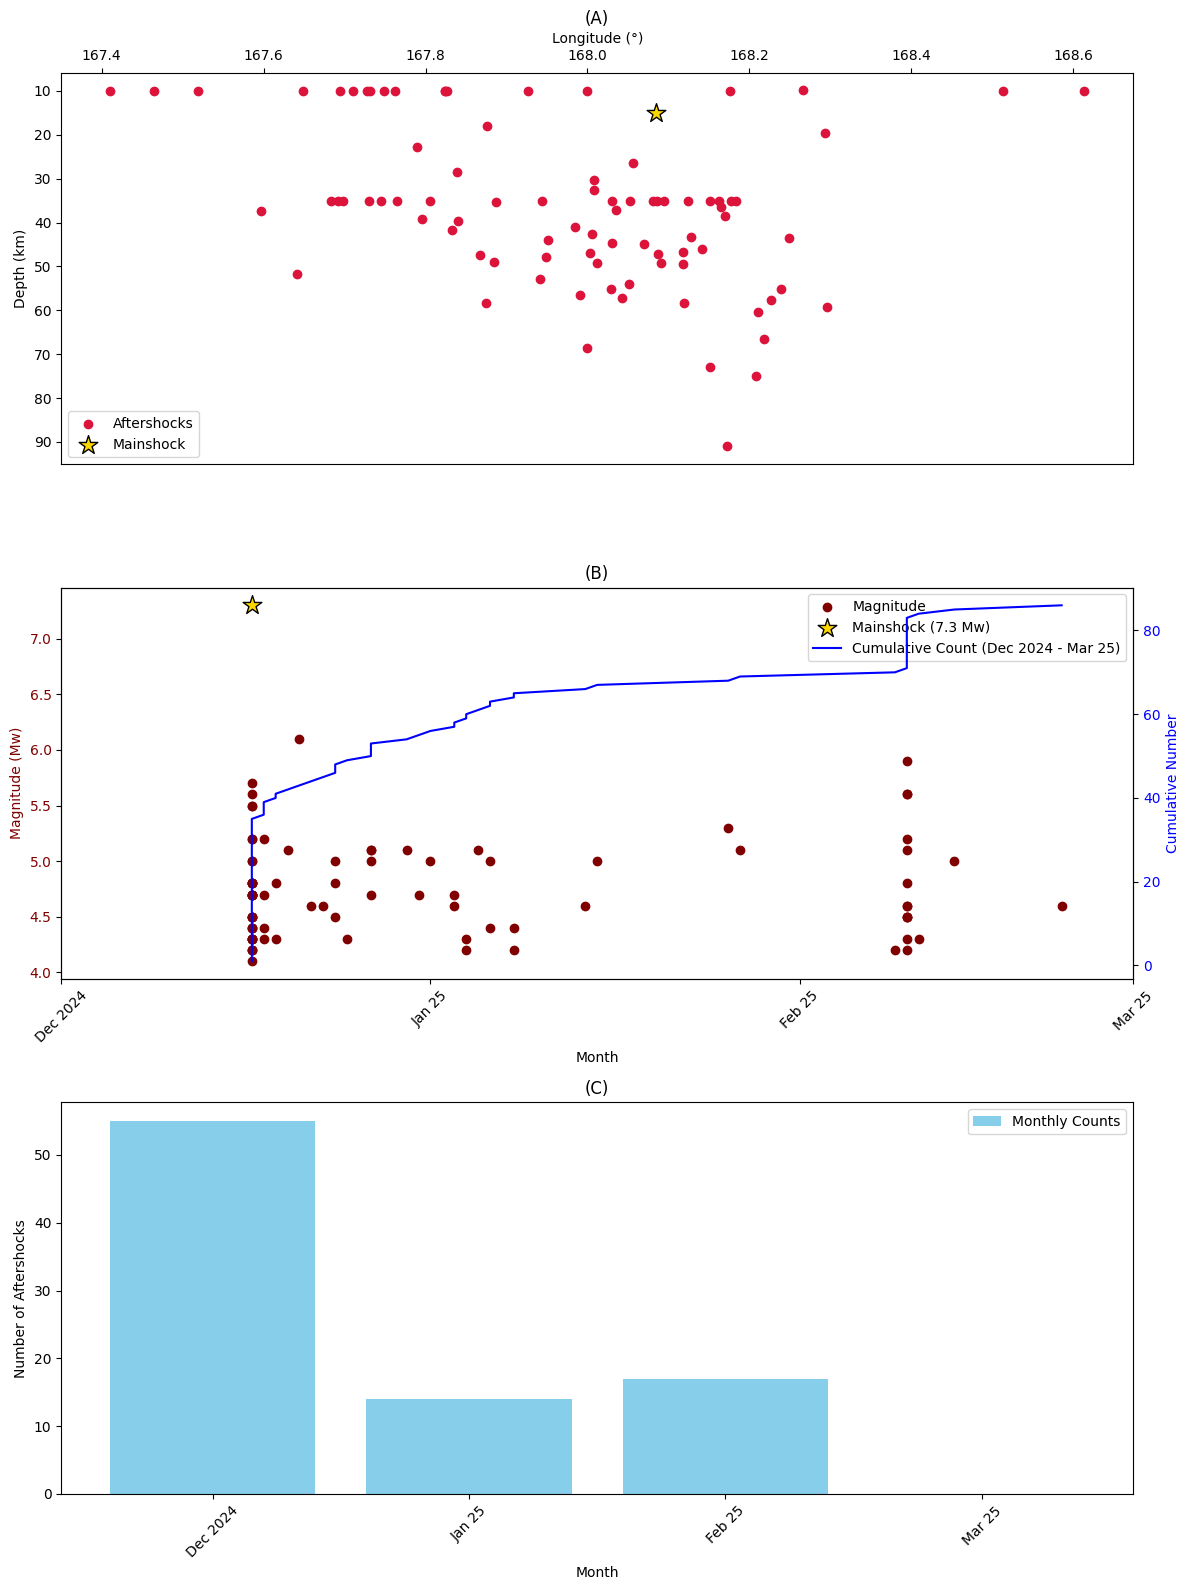

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
aftershocks = pd.read_csv('/content/aftershocks_M7p3_GK (1).csv')
aftershocks['date'] = pd.to_datetime(dict(year=aftershocks['yyyy'], month=aftershocks['mm'], day=aftershocks['dd']))

# Filter for Dec 2024 - Apr 2025
start_date = pd.to_datetime('2024-12-01')
end_date = pd.to_datetime('2025-03-01')
aftershocks = aftershocks[(aftershocks['date'] >= start_date) & (aftershocks['date'] <= end_date)]
aftershocks = aftershocks.sort_values('date').reset_index(drop=True)

# Define x-axis labels/ticks for months
month_labels = ['Dec 2024', 'Jan 25', 'Feb 25', 'Mar 25']
month_dates = pd.to_datetime(['2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01'])
aftershocks['year_month'] = aftershocks['date'].dt.to_period('M')

# Create figure
fig, axs = plt.subplots(3, 1, figsize=(12, 16))

# --- 1. Depth vs Longitude ---
ax0 = axs[0]
ax0.scatter(aftershocks['longitude'], aftershocks['depth'], c='crimson', label='Aftershocks')
ax0.scatter(168.0842, 15, s=200, marker='*', c='gold', edgecolor='black', label='Mainshock')
ax0.invert_yaxis()
ax0.xaxis.set_label_position('top')
ax0.xaxis.tick_top()
ax0.set_xlabel('Longitude (°)')
ax0.set_ylabel('Depth (km)')
ax0.set_title('(A)')
ax0.legend()

# --- 2. Magnitude vs Month with Cumulative Number ---
ax1 = axs[1]
scat = ax1.scatter(aftershocks['date'], aftershocks['mag'], c='maroon', label='Magnitude')
ax1.set_xlabel('Month')
ax1.set_ylabel('Magnitude (Mw)', color='maroon')
ax1.set_title('(B)')
ax1.set_xticks(month_dates)
ax1.set_xticklabels(month_labels)
ax1.set_xlim(month_dates[0], month_dates[-1])
plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.tick_params(axis='y', labelcolor='maroon')

# Highlight mainshock on 17 Dec 2024
mainshock_date = pd.to_datetime('2024-12-17')
mainshock_mag = 7.3
mainshock_plot = ax1.scatter(mainshock_date, mainshock_mag, s=200, marker='*', c='gold', edgecolor='black', label='Mainshock (7.3 Mw)')

# Secondary y-axis - cumulative number
ax1b = ax1.twinx()
line_label = f'Cumulative Count ({month_labels[0]} - {month_labels[-1]})'
line, = ax1b.plot(aftershocks['date'], range(1, len(aftershocks) + 1), c='blue', label=line_label)
ax1b.set_ylabel('Cumulative Number', color='blue')
ax1b.tick_params(axis='y', labelcolor='blue')

# Combined legend
handles = [scat, mainshock_plot, line]
labels = [h.get_label() for h in handles]
ax1.legend(handles, labels, loc='upper right')

# --- 3. Monthly aftershock bar plot ---
ax2 = axs[2]
all_periods = pd.period_range('2024-12', '2025-03', freq='M')
monthly_counts = aftershocks.groupby('year_month').size().reindex(all_periods, fill_value=0)
ax2.bar(month_labels, monthly_counts.values, color='skyblue', label='Monthly Counts')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Aftershocks')
ax2.set_title('(C)')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.savefig('/content/combined_plots_mainshock_highlighted.png', dpi=600)
plt.show()


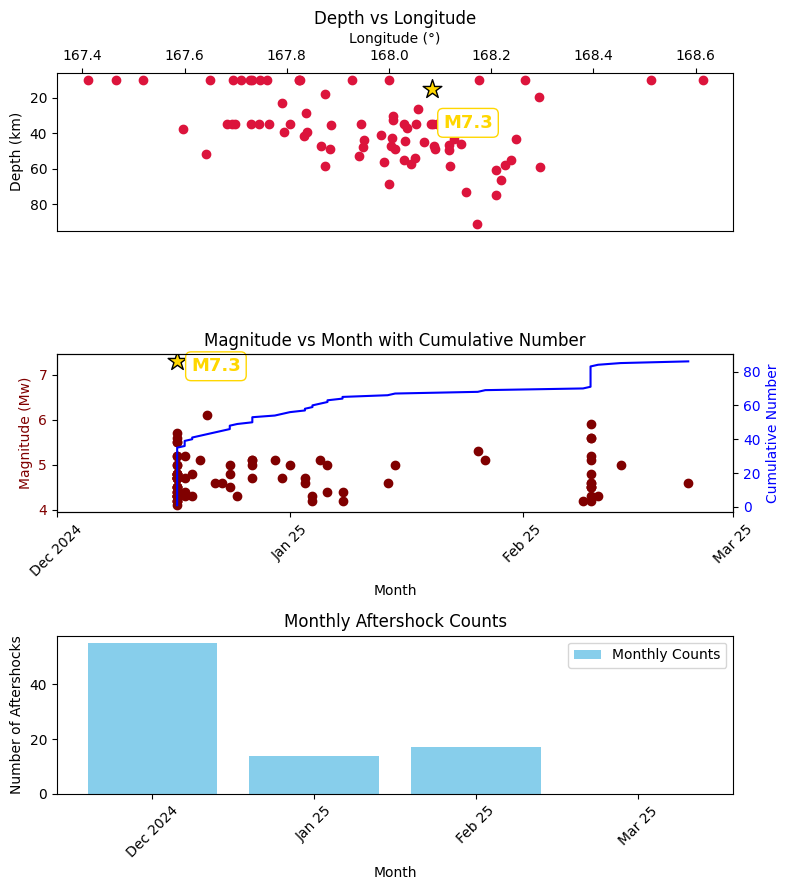

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
aftershocks = pd.read_csv('/content/aftershocks_M7p3_GK (1).csv')
aftershocks['date'] = pd.to_datetime(dict(year=aftershocks['yyyy'], month=aftershocks['mm'], day=aftershocks['dd']))

# Filter for Dec 2024 - Apr 2025
start_date = pd.to_datetime('2024-12-01')
end_date = pd.to_datetime('2025-03-01')
aftershocks = aftershocks[(aftershocks['date'] >= start_date) & (aftershocks['date'] <= end_date)]
aftershocks = aftershocks.sort_values('date').reset_index(drop=True)

# Month labels/ticks
month_labels = ['Dec 2024', 'Jan 25', 'Feb 25', 'Mar 25']
month_dates = pd.to_datetime(['2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01'])
aftershocks['year_month'] = aftershocks['date'].dt.to_period('M')

# Mainshock info
mainshock_date = pd.to_datetime('2024-12-17')
mainshock_mag = 7.3
mainshock_longitude = 168.0842
mainshock_depth = 15

# Figure
fig, axs = plt.subplots(3, 1, figsize=(8, 9))
# --- 1. Depth vs Longitude ---
ax0 = axs[0]
ax0.scatter(aftershocks['longitude'], aftershocks['depth'], c='crimson')
mainshock_pt = ax0.scatter(mainshock_longitude, mainshock_depth, s=200, marker='*', c='gold', edgecolor='black')
ax0.annotate('M7.3', xy=(mainshock_longitude, mainshock_depth), xytext=(8, -18), textcoords='offset points',
             ha='left', va='top', fontsize=13, fontweight='bold', color='gold', bbox=dict(facecolor='white', edgecolor='gold', boxstyle='round,pad=0.3'))
ax0.invert_yaxis()
ax0.xaxis.set_label_position('top')
ax0.xaxis.tick_top()
ax0.set_xlabel('Longitude (°)')
ax0.set_ylabel('Depth (km)')
ax0.set_title('Depth vs Longitude')

# --- 2. Magnitude vs Month, cumulative, and annotated mainshock ---
ax1 = axs[1]
ax1.scatter(aftershocks['date'], aftershocks['mag'], c='maroon')
ax1.set_xlabel('Month')
ax1.set_ylabel('Magnitude (Mw)', color='maroon')
ax1.set_title('Magnitude vs Month with Cumulative Number')
ax1.set_xticks(month_dates)
ax1.set_xticklabels(month_labels)
ax1.set_xlim(month_dates[0], month_dates[-1])
plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.tick_params(axis='y', labelcolor='maroon')
# Mainshock star and annotation
mainshock_plt2 = ax1.scatter(mainshock_date, mainshock_mag, s=200, marker='*', c='gold', edgecolor='black')
ax1.annotate('M7.3', xy=(mainshock_date, mainshock_mag), xytext=(10, -10), textcoords='offset points',
             ha='left', va='bottom', fontsize=13, fontweight='bold', color='gold', bbox=dict(facecolor='white', edgecolor='gold', boxstyle='round,pad=0.3'))
# Cumulative
ax1b = ax1.twinx()
ax1b.plot(aftershocks['date'], range(1, len(aftershocks) + 1), c='blue')
ax1b.set_ylabel('Cumulative Number', color='blue')
ax1b.tick_params(axis='y', labelcolor='blue')

# --- 3. Monthly aftershock bar plot ---
ax2 = axs[2]
all_periods = pd.period_range('2024-12', '2025-03', freq='M')
monthly_counts = aftershocks.groupby('year_month').size().reindex(all_periods, fill_value=0)
ax2.bar(month_labels, monthly_counts.values, color='skyblue', label='Monthly Counts')
ax2.set_xlabel('Month')
ax2.set_ylabel('Number of Aftershocks')
ax2.set_title('Monthly Aftershock Counts')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

plt.tight_layout()
plt.savefig('/content/combined_plots_mainshock_annotated_both.png', dpi=600)
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load data
aftershocks = pd.read_csv('/content/aftershocks_M7p3_GK (1).csv')
aftershocks['date'] = pd.to_datetime(dict(year=aftershocks['yyyy'], month=aftershocks['mm'], day=aftershocks['dd']))

# Filter dates
start_date = pd.to_datetime('2024-12-01')
end_date = pd.to_datetime('2025-03-01')
aftershocks = aftershocks[(aftershocks['date'] >= start_date) & (aftershocks['date'] <= end_date)]
aftershocks = aftershocks.sort_values('date').reset_index(drop=True)

# Month ticks and labels
month_labels = ['Dec 2024', 'Jan 25', 'Feb 25', 'Mar 25']
month_dates = pd.to_datetime(['2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01'])
aftershocks['year_month'] = aftershocks['date'].dt.to_period('M')

# Mainshock details
mainshock_date = pd.to_datetime('2024-12-17')
mainshock_mag = 7.3
mainshock_longitude = 168.0842
mainshock_depth = 15

# Figure fitting half A4
fig, axs = plt.subplots(3, 1, figsize=(8, 9), dpi=600)

fig.subplots_adjust(left=0.1, right=0.95, top=0.95, bottom=0.15, hspace=0.4)

# Plot 1: Depth vs Longitude
ax0 = axs[0]
ax0.scatter(aftershocks['longitude'], aftershocks['depth'], c='crimson')
ax0.scatter(mainshock_longitude, mainshock_depth, s=80, marker='*', c='gold', edgecolor='black')
ax0.annotate('M7.3', xy=(mainshock_longitude, mainshock_depth), xytext=(5, -12), textcoords='offset points',
             ha='left', va='top', fontsize=8, fontweight='bold', color='gold',
             bbox=dict(facecolor='white', edgecolor='gold', boxstyle='round,pad=0.3'))
ax0.invert_yaxis()
ax0.xaxis.set_label_position('top')
ax0.xaxis.tick_top()
ax0.set_xlabel('Longitude (°)', fontsize=8)
ax0.set_ylabel('Depth (km)', fontsize=8)
ax0.set_title('Depth vs Longitude', fontsize=9)
ax0.tick_params(axis='both', which='major', labelsize=7)

# Plot 2: Magnitude vs Month + Cumulative Number
ax1 = axs[1]
ax1.scatter(aftershocks['date'], aftershocks['mag'], c='maroon', s=15)
ax1.set_xlabel('Month', fontsize=8)
ax1.set_ylabel('Magnitude (Mw)', color='maroon', fontsize=8)
ax1.set_title('Magnitude vs Month with Cumulative Number', fontsize=9)

ax1.set_xticks(month_dates)
ax1.set_xticklabels(month_labels, fontsize=7)
ax1.set_xlim(month_dates[0], month_dates[-1])
ax1.tick_params(axis='y', labelcolor='maroon', labelsize=7)

ax1.scatter(mainshock_date, mainshock_mag, s=80, marker='*', c='gold', edgecolor='black')
ax1.annotate('M7.3', xy=(mainshock_date, mainshock_mag), xytext=(7, -10), textcoords='offset points',
             ha='left', va='bottom', fontsize=8, fontweight='bold', color='gold',
             bbox=dict(facecolor='white', edgecolor='gold', boxstyle='round,pad=0.3'))

ax1b = ax1.twinx()
ax1b.plot(aftershocks['date'], range(1, len(aftershocks) + 1), c='blue', linewidth=0.8)
ax1b.set_ylabel('Cumulative Number', color='blue', fontsize=8)
ax1b.tick_params(axis='y', labelcolor='blue', labelsize=7)

# Plot 3: Monthly aftershock counts bar plot
ax2 = axs[2]
all_periods = pd.period_range('2024-12', '2025-03', freq='M')
monthly_counts = aftershocks.groupby('year_month').size().reindex(all_periods, fill_value=0)
ax2.bar(month_labels, monthly_counts.values, color='blue', width=0.4)  # width added here
ax2.set_xlabel('Month', fontsize=8)
ax2.set_ylabel('Number of Aftershocks', fontsize=8)
ax2.set_title('Monthly Aftershock Counts', fontsize=9)
ax2.tick_params(axis='x', rotation=45, labelsize=7)
ax2.tick_params(axis='y', labelsize=7)

plt.tight_layout()
plt.savefig('/content/combined_plots_half_A4.png', dpi=600)
plt.show()



FileNotFoundError: [Errno 2] No such file or directory: '/content/aftershocks_M7p3_GK (1).csv'

/tmp/ipython-input-1669316636.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


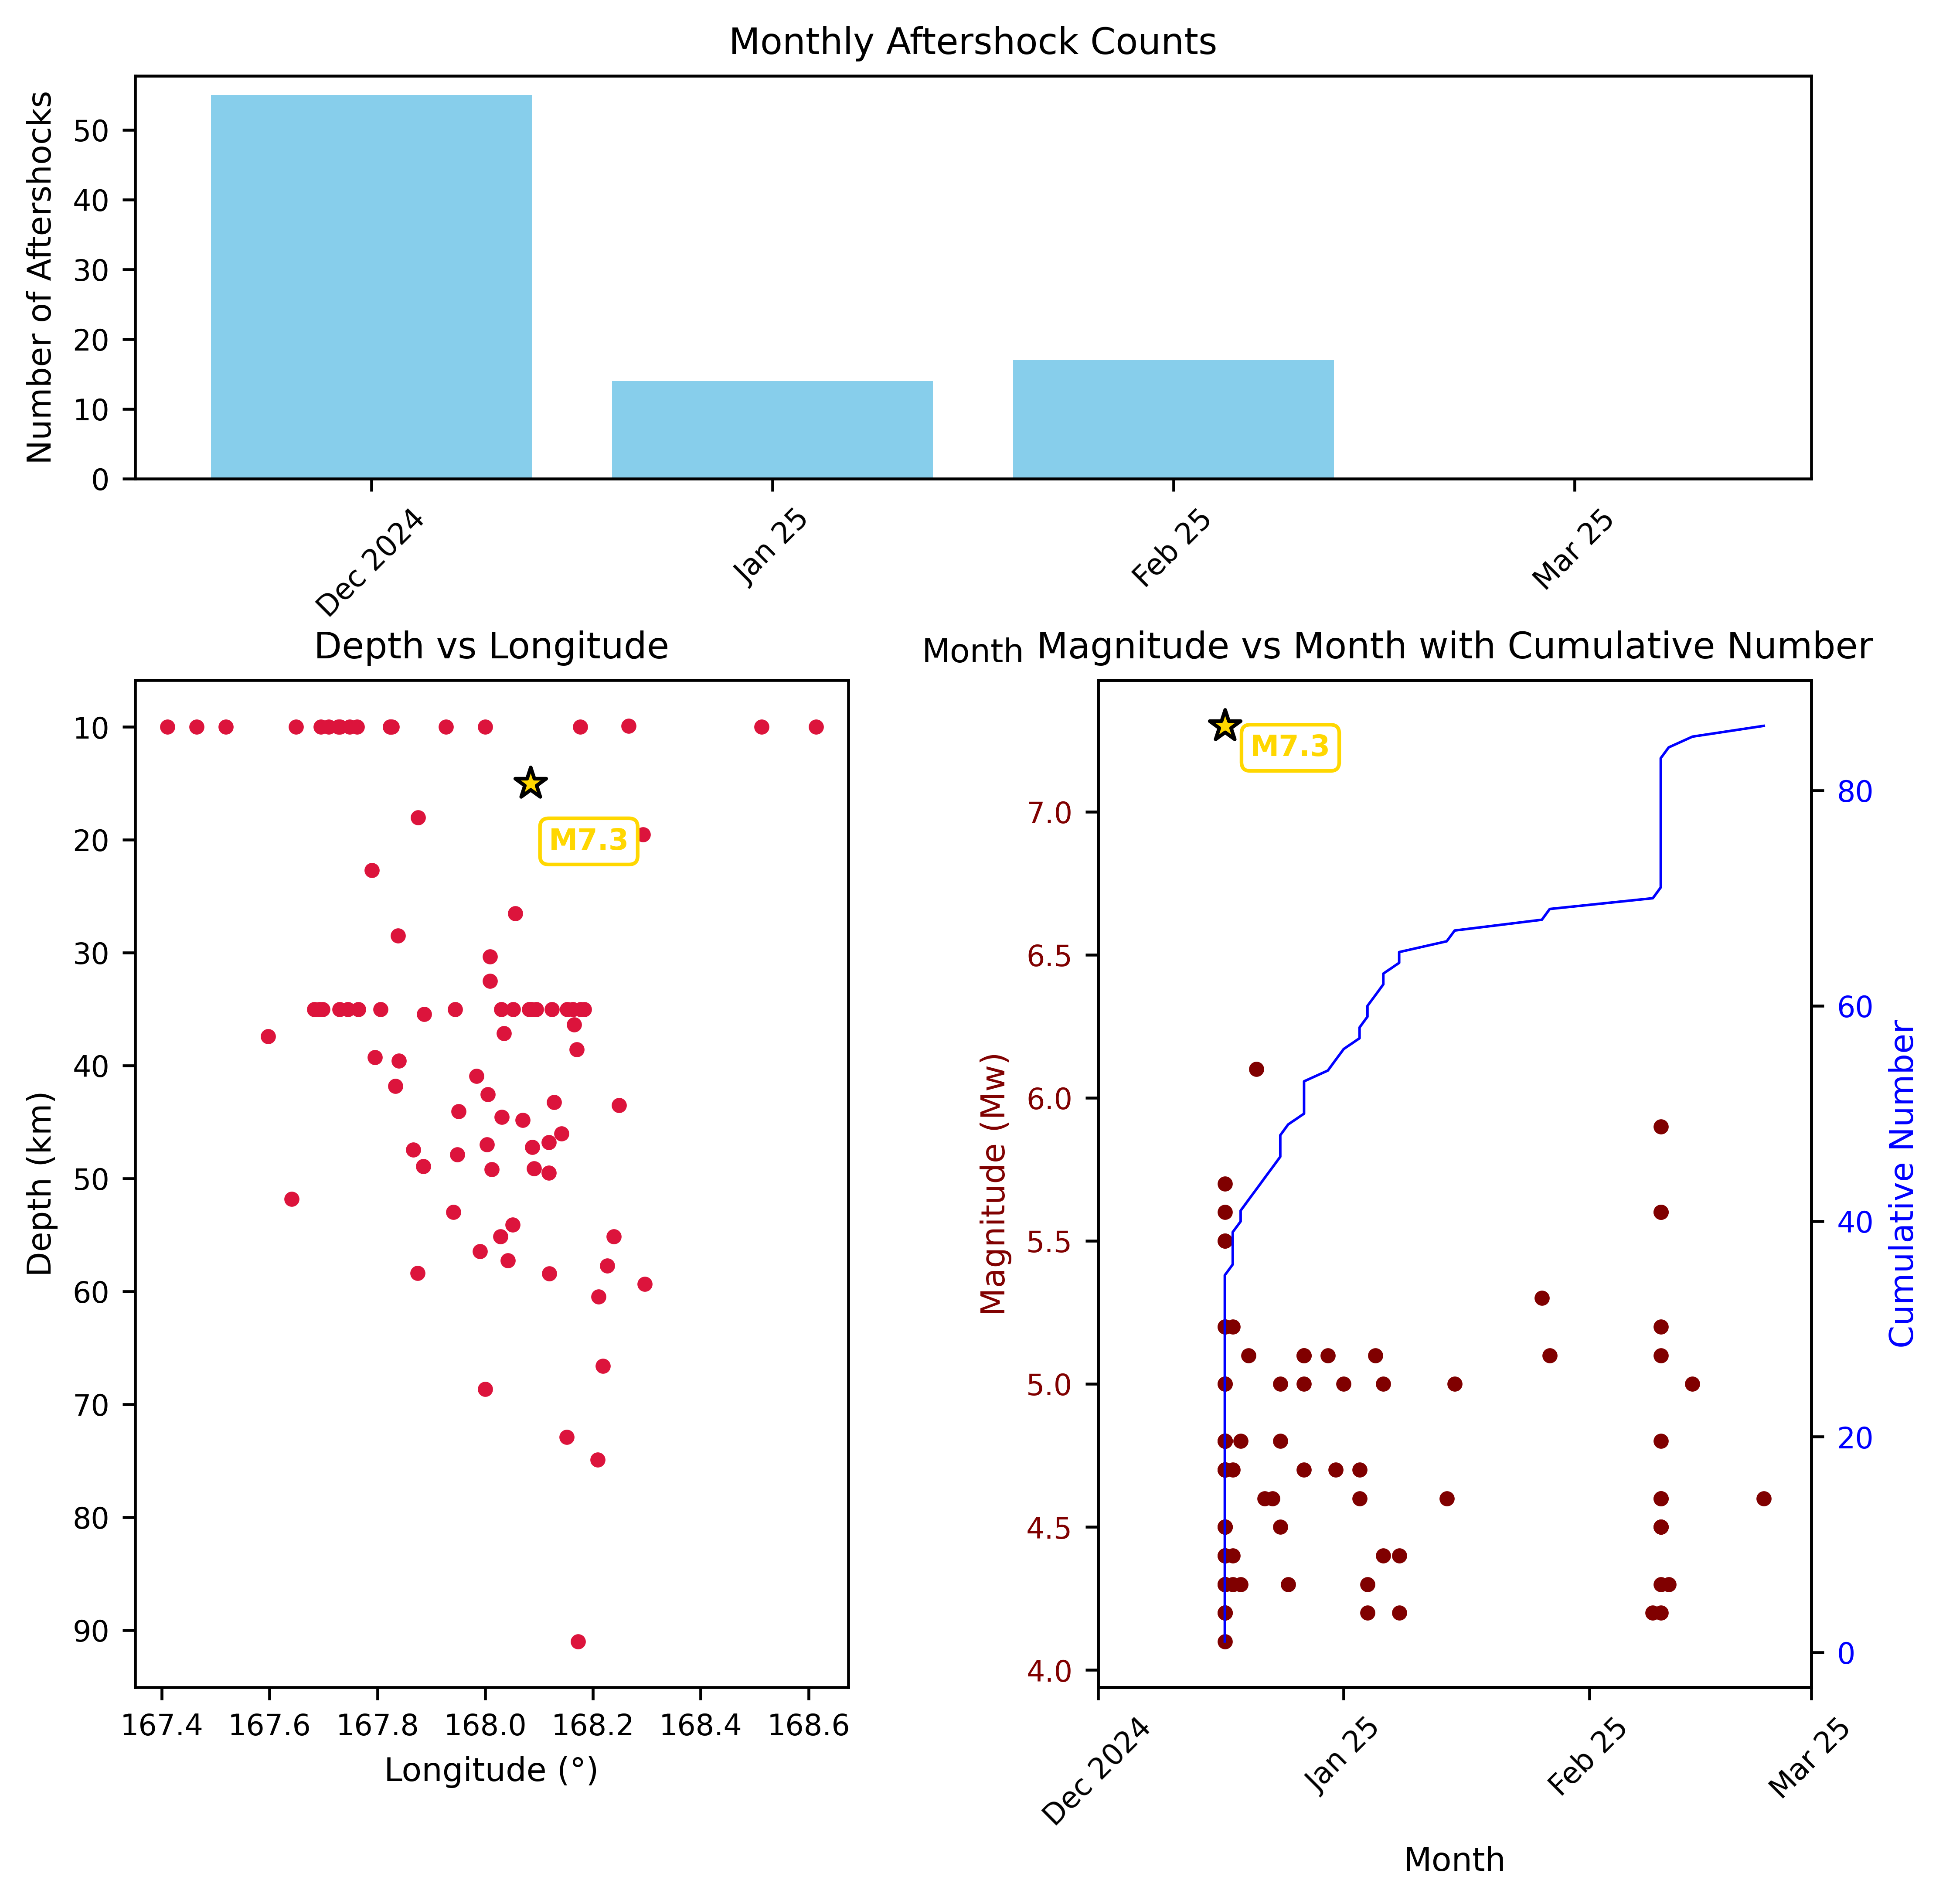

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

# Load data
aftershocks = pd.read_csv('/content/aftershocks_M7p3_GK (1).csv')
aftershocks['date'] = pd.to_datetime(dict(year=aftershocks['yyyy'], month=aftershocks['mm'], day=aftershocks['dd']))

# Filter dates
start_date = pd.to_datetime('2024-12-01')
end_date = pd.to_datetime('2025-03-01')
aftershocks = aftershocks[(aftershocks['date'] >= start_date) & (aftershocks['date'] <= end_date)]
aftershocks = aftershocks.sort_values('date').reset_index(drop=True)

# Month ticks and labels
month_labels = ['Dec 2024', 'Jan 25', 'Feb 25', 'Mar 25']
month_dates = pd.to_datetime(['2024-12-01', '2025-01-01', '2025-02-01', '2025-03-01'])
aftershocks['year_month'] = aftershocks['date'].dt.to_period('M')

# Mainshock details
mainshock_date = pd.to_datetime('2024-12-17')
mainshock_mag = 7.3
mainshock_longitude = 168.0842
mainshock_depth = 15

# Create figure with GridSpec
fig = plt.figure(figsize=(8.27, 8), dpi=600)
gs = GridSpec(3, 2, figure=fig, height_ratios=[2, 1, 3], width_ratios=[1, 1], hspace=0.5, wspace=0.35)

# 3rd plot spanning top row (both columns)
ax_top = fig.add_subplot(gs[0, :])
all_periods = pd.period_range('2024-12', '2025-03', freq='M')
monthly_counts = aftershocks.groupby('year_month').size().reindex(all_periods, fill_value=0)
ax_top.bar(month_labels, monthly_counts.values, color='skyblue')
ax_top.set_title('Monthly Aftershock Counts', fontsize=10)
ax_top.set_xlabel('Month', fontsize=9)
ax_top.set_ylabel('Number of Aftershocks', fontsize=9)
ax_top.tick_params(axis='x', rotation=45, labelsize=8)
ax_top.tick_params(axis='y', labelsize=8)

# 1st plot bottom left
ax1 = fig.add_subplot(gs[1:, 0])
ax1.scatter(aftershocks['longitude'], aftershocks['depth'], c='crimson', s=10)
ax1.scatter(mainshock_longitude, mainshock_depth, s=80, marker='*', c='gold', edgecolor='black')
ax1.annotate('M7.3', xy=(mainshock_longitude, mainshock_depth), xytext=(5, -12), textcoords='offset points',
             ha='left', va='top', fontsize=8, fontweight='bold', color='gold',
             bbox=dict(facecolor='white', edgecolor='gold', boxstyle='round,pad=0.3'))
ax1.invert_yaxis()
ax1.set_title('Depth vs Longitude', fontsize=10)
ax1.set_xlabel('Longitude (°)', fontsize=9)
ax1.set_ylabel('Depth (km)', fontsize=9)
ax1.tick_params(axis='both', which='major', labelsize=8)

# 2nd plot bottom right
ax2 = fig.add_subplot(gs[1:, 1])
ax2.scatter(aftershocks['date'], aftershocks['mag'], c='maroon', s=10)
ax2.scatter(mainshock_date, mainshock_mag, s=80, marker='*', c='gold', edgecolor='black')
ax2.annotate('M7.3', xy=(mainshock_date, mainshock_mag), xytext=(7, -10), textcoords='offset points',
             ha='left', va='bottom', fontsize=8, fontweight='bold', color='gold',
             bbox=dict(facecolor='white', edgecolor='gold', boxstyle='round,pad=0.3'))
ax2.set_title('Magnitude vs Month with Cumulative Number', fontsize=10)
ax2.set_xlabel('Month', fontsize=9)
ax2.set_ylabel('Magnitude (Mw)', fontsize=9, color='maroon')
ax2.set_xticks(month_dates)
ax2.set_xticklabels(month_labels, fontsize=8)
ax2.set_xlim(month_dates[0], month_dates[-1])
ax2.tick_params(axis='y', labelcolor='maroon', labelsize=8)
plt.setp(ax2.get_xticklabels(), rotation=45)

ax2b = ax2.twinx()
ax2b.plot(aftershocks['date'], range(1, len(aftershocks) + 1), c='blue', linewidth=0.7)
ax2b.set_ylabel('Cumulative Number', fontsize=9, color='blue')
ax2b.tick_params(axis='y', labelcolor='blue', labelsize=8)

plt.tight_layout()
plt.savefig('/content/combined_plots_custom_layout.png', dpi=600)
plt.show()
